In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from econml.causal_forest import CausalForestDML
from econml.dml import LinearDML
# User-written modules
import sys
sys.path.append('..')
import src.config as cfg
import src.features as ft
from src.dmlutils import DML_diagnostics

In [7]:
df = pd.read_csv(Path('../data/FARS-data-full-sample.txt'), sep='\t')
# The replication does not use whether child seat or belt were improperly used, and thereafter drops rows with missing values in them
df_repl = df[[feat for feat in df.columns if not feat.startswith('imp')]]
df_repl = df_repl[~df_repl.isna().max(axis=1)]
df_repl['modelyr'] = df_repl['modelyr'].astype(int)
df_repl = df_repl[df_repl['year']<=2003]
print(len(df_repl))

38455


In [8]:
pipe = ft.construct_data_pipeline(pd_output=True)
cv_splitter = KFold(2, shuffle=True, random_state=cfg.random_state)

## Full sample replication with DML

In [23]:
y = df_repl['death']
T = df_repl['restraint']
W = df_repl[[col for col in df_repl.columns if col not in ['lapbelt', 'lapshould', 'childseat']]]

In [25]:
%%time
model_t = HistGradientBoostingClassifier(max_iter=100, n_iter_no_change=10, max_depth=10, early_stopping=True, random_state=cfg.random_state)
model_y = HistGradientBoostingRegressor(max_iter=100, n_iter_no_change=10, max_depth=10, early_stopping=True, random_state=cfg.random_state)
dml = LinearDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=True, fit_cate_intercept=True)
dml.fit(y, T.values, W=pipe.fit_transform(W))

Wall time: 8.14 s


In [26]:
inf = dml.intercept__inference()
inf.summary_frame()

point_estimate  stderr   zstat  pvalue  \
X              T                                                              
cate_intercept T0_1_childseat                -0.127   0.006 -20.818     0.0   
               T0_2_lap only belt            -0.110   0.007 -16.891     0.0   
               T0_3_lap/should belt          -0.148   0.007 -21.035     0.0   

                                     ci_lower  ci_upper  
X              T                                         
cate_intercept T0_1_childseat          -0.137    -0.117  
               T0_2_lap only belt      -0.121    -0.100  
               T0_3_lap/should belt    -0.160    -0.137

### Comparison with OLS benchmark

In [28]:
%%time
Tb = T.str[0].astype(int)>0
model_t = LinearRegression()
model_y = LinearRegression()
bmark = LinearDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=False, fit_cate_intercept=True)

bmark.fit(y, Tb.values, W=pipe.fit_transform(W))

Wall time: 428 ms


In [29]:
inf = bmark.intercept__inference()
inf.summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
cate_intercept,-0.118,0.005,-22.469,0.0,-0.127,-0.109


In [35]:
diag = DML_diagnostics(dml)
bdiag = DML_diagnostics(bmark)
pd.DataFrame([
        [r2_score(y, diag.predict_y(W=pipe.transform(W))), r2_score(T.str[0].astype(int)>0, diag.predict_T(W=pipe.transform(W)))],
        [r2_score(y, bdiag.predict_y(W=pipe.transform(W))), r2_score(Tb, bdiag.predict_T(W=pipe.transform(W)))]
    ]
    , index=['DML', 'OLS benchmark'], columns=['R2 y', 'R2 T']
)

Bechmark: Out-of-sample R2 for DML and OLS models


,R2 y,R2 T
DML,0.085001,0.366853
OLS benchmark,0.060335,0.357309


## Selected sample replication (causal)

In [39]:
df = pd.read_csv(Path('../data/FARS-data-selection-sample.txt'), sep='\t')
# The replication does not use whether child seat or belt were improperly used, and thereafter drops rows with missing values in them
df_sel = df[[feat for feat in df.columns if not feat.startswith('imp')]]
df_sel = df_sel[~df_sel.isna().max(axis=1)]
df_sel['modelyr'] = df_sel['modelyr'].astype(int)
df_sel = df_sel[df_sel['year']<=2003]

In [40]:
y = df_sel['death']
T = df_sel['restraint']
W = df_sel[[col for col in df_sel.columns if col not in ['lapbelt', 'lapshould', 'childseat']]]

In [43]:
%%time
model_t = HistGradientBoostingClassifier(max_iter=100, n_iter_no_change=10, max_depth=10, early_stopping=True, random_state=cfg.random_state)
model_y = HistGradientBoostingRegressor(max_iter=100, n_iter_no_change=10, max_depth=10, early_stopping=True, random_state=cfg.random_state)
dml = LinearDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=True, fit_cate_intercept=True)
dml.fit(y, T.values, W=pipe.fit_transform(W))

Wall time: 2.91 s


In [44]:
inf = dml.intercept__inference()
inf.summary_frame()

point_estimate  stderr  zstat  pvalue  \
X              T                                                             
cate_intercept T0_1_childseat                -0.047   0.007 -6.715     0.0   
               T0_2_lap only belt            -0.048   0.007 -6.850     0.0   
               T0_3_lap/should belt          -0.054   0.007 -7.252     0.0   

                                     ci_lower  ci_upper  
X              T                                         
cate_intercept T0_1_childseat          -0.058    -0.035  
               T0_2_lap only belt      -0.059    -0.036  
               T0_3_lap/should belt    -0.067    -0.042

In [47]:
diag = DML_diagnostics(dml)
pd.DataFrame(
    [[r2_score(y, diag.predict_y(W=pipe.transform(W))), r2_score(T.str[0].astype(int)>0, diag.predict_T(W=pipe.transform(W)))]],
    index=['DML'], columns=['R2 y', 'R2 T']
)

,R2 y,R2 T
DML,0.015108,0.403582


## Causal forests

For simplicity, we collapse the treatment arms into havign any child protection (any of the treatment arms) or not.

In [48]:
from copy import deepcopy
feats = deepcopy(ft.feat_type)
feats['categorical'] = ['crashtm']
feats['ordinal'] = feats['ordinal'] + ['year', 'modelyr']
pipe = ft.construct_data_pipeline(feat_type=feats, pd_output=True)

In [55]:
y = df_sel['death']
T = df_sel[['childseat', 'lapbelt', 'lapshould']].max(axis=1).astype(int)
X = df_sel[[col for col in df_sel.columns if col not in ['lapbelt', 'lapshould', 'childseat']]]
X = pipe.fit_transform(W)

In [56]:
%%time
model_t = HistGradientBoostingClassifier(max_iter=100, n_iter_no_change=10, max_depth=10, early_stopping=True, random_state=cfg.random_state)
model_y = HistGradientBoostingRegressor(max_iter=100, n_iter_no_change=10, max_depth=10, early_stopping=True, random_state=cfg.random_state)
cf = CausalForestDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=True, random_state=cfg.random_state)
cf.fit(y, T.values, X=X)

Wall time: 2.25 s


In [57]:
cates = cf.marginal_effect(T, X=X)
print(cates.mean())
cf.summary()

-0.044095519462886514
Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,-0.033,0.011,-3.055,0.002,-0.05,-0.015
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.026,0.021,-1.244,0.213,-0.06,0.008
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.036,0.012,-3.049,0.002,-0.056,-0.017


### Characterization of CATEs

In [67]:
cinf = cf.const_marginal_effect_inference(X)
cinf = cinf.conf_int()

In [85]:
cinf[1].mean()

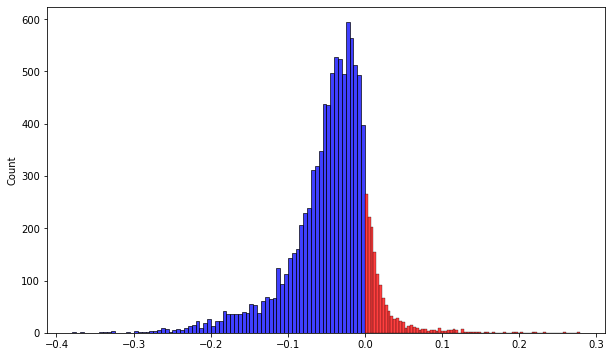

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(10, 6))

sns.histplot(x=cates[cates<0].reshape(-1), ax=ax, color='blue')
sns.histplot(x=cates[cates>0].reshape(-1), ax=ax, color='red')
plt.show() 

In [23]:
pd.DataFrame(cf.feature_importances(), index=X.columns, columns=['importance']).sort_values('importance', ascending=False).head(7)

,importance
year,0.187570
thoulbs_I,0.177703
splmU55,0.172001
numcrash,0.132299
modelyr,0.124369
row1,0.024720
lowviol,0.021191


In [24]:
codeweight = X['thoulbs_I'].copy()
codeweight[X['thoulbs_I']<1] = 'Missing weight'
codeweight[X['thoulbs_I']>1] = '<3500 lbs'
codeweight[X['thoulbs_I']>3.5] = '>3500 lbs'

In [25]:
codeweight.value_counts()

<3500 lbs         5126
>3500 lbs         2645
Missing weight    2557
Name: thoulbs_I, dtype: int64

In [85]:
hm = (
    pd.concat([pd.DataFrame(cates, columns=['cate'], index=X.index), X[['year', 'modelyr']]], axis=1)
    .groupby(['year', 'modelyr']).agg(['mean', 'count'])
    .reset_index()
)
hm.columns = ['year', 'modelyr', 'mean', 'count']

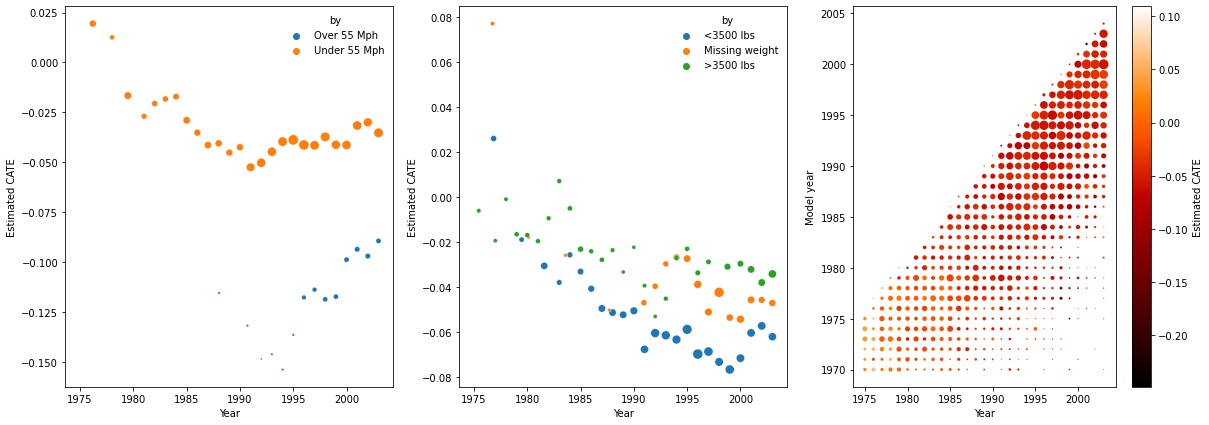

In [112]:
from src.dmlutils import binscatter
fig, ax = plt.subplots(1,3, figsize=(20, 7), sharex=True)

toplot = binscatter(y=pd.DataFrame(cates), x=X[['year']], by=X['splmU55'], nbins=50)
sns.scatterplot(data=toplot, x='x', y='y', hue='by', s=100*toplot['count']/toplot['count'].max(), ax=ax[0])
ax[0].legend(handles= ax[0].legend_.legendHandles, labels = ['Over 55 Mph', 'Under 55 Mph'], frameon=False, title='by')
ax[0].set_ylabel('Estimated CATE')
ax[0].set_xlabel('Year')

toplot = binscatter(y=pd.DataFrame(cates), x=X[['year']], by=codeweight, nbins=50)
sns.scatterplot(data=toplot, x='x', y='y', hue='by', s=100*toplot['count']/toplot['count'].max(), ax=ax[1])
ax[1].legend(frameon=False, title='by')
ax[1].set_ylabel('Estimated CATE')
ax[1].set_xlabel('Year')


sns.scatterplot(data=hm, x='year', y='modelyr', hue='mean', s=100*hm['count']/hm['count'].max(), ax=ax[2], palette='gist_heat')
norm = plt.Normalize(hm['mean'].min(), hm['mean'].max())
sm = plt.cm.ScalarMappable(cmap="gist_heat", norm=norm)
sm.set_array([])
ax[2].get_legend().remove()
ax[2].figure.colorbar(sm).set_label('Estimated CATE')
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Model year')

plt.show()

In [16]:
from src.dmlutils import DML_diagnostics
diag = DML_diagnostics(dml)

In [17]:
X.value_counts()

lapbelt  lapshould
0.0      0.0          41089
         1.0           8803
1.0      0.0           6182
dtype: int64

In [18]:
pipe.transform(W).shape

In [19]:
dml.models_y[0][0].n_features_in_

In [20]:
from econml.dml import CausalForestDML

In [21]:
model_t = HistGradientBoostingRegressor(max_iter=100, n_iter_no_change=10, max_depth=10, early_stopping=True, random_state=cfg.random_state)
model_y = HistGradientBoostingRegressor(max_iter=100, n_iter_no_change=10, max_depth=10, early_stopping=True, random_state=cfg.random_state)

cf = CausalForestDML(model_y=model_y, model_t=model_t, cv=cv_splitter)

In [ ]:
cf = 

In [40]:
# print(r2_score())
diag.predict_y(X=X, W=pipe.transform(W))

ValueError: X has 117 features but this estimator was trained with 351 features.

In [54]:
# diag.get_score_T(dml, r2_score, pipe.fit_transform(df_repl), T.str.split('_').str[0].astype(int))


0.08364475851550968


In [8]:
dml.model_final_._var
# dml.model_final_.coef_

NameError: name 'dml' is not defined

In [37]:
from src.dmlutils import DML_diagnostics
from sklearn.metrics import r2_score
diag = DML_diagnostics(cv_splitter)

In [176]:
from sklearn.preprocessing import OneHotEncoder
test = df_repl[['suv', 'weekend']]

enc = OneHotEncoder(sparse=False)
enc.fit_transform(test)
enc.get_feature_names(test.columns)

array(['suv_0', 'suv_1', 'weekend_0', 'weekend_1'], dtype=object)

In [225]:
pipe = ft.construct_data_pipeline(pd_output=True)
pipe.fit_transform(df_repl)

['year_1975' 'year_1976' 'year_1977' 'year_1978' 'year_1979' 'year_1980'
 'year_1981' 'year_1982' 'year_1983' 'year_1984' 'year_1985' 'year_1986'
 'year_1987' 'year_1988' 'year_1989' 'year_1990' 'year_1991' 'year_1992'
 'year_1993' 'year_1994' 'year_1995' 'year_1996' 'year_1997' 'year_1998'
 'year_1999' 'year_2000' 'year_2001' 'year_2002' 'year_2003' 'year_2004'
 'year_2005' 'year_2006' 'year_2007' 'year_2008' 'year_2009'
 'modelyr_1970.0' 'modelyr_1971.0' 'modelyr_1972.0' 'modelyr_1973.0'
 'modelyr_1974.0' 'modelyr_1975.0' 'modelyr_1976.0' 'modelyr_1977.0'
 'modelyr_1978.0' 'modelyr_1979.0' 'modelyr_1980.0' 'modelyr_1981.0'
 'modelyr_1982.0' 'modelyr_1983.0' 'modelyr_1984.0' 'modelyr_1985.0'
 'modelyr_1986.0' 'modelyr_1987.0' 'modelyr_1988.0' 'modelyr_1989.0'
 'modelyr_1990.0' 'modelyr_1991.0' 'modelyr_1992.0' 'modelyr_1993.0'
 'modelyr_1994.0' 'modelyr_1995.0' 'modelyr_1996.0' 'modelyr_1997.0'
 'modelyr_1998.0' 'modelyr_1999.0' 'modelyr_2000.0' 'modelyr_2001.0'
 'modelyr_2002.0' 'mod

,year_1975,year_1976,year_1977,year_1978,year_1979,year_1980,year_1981,year_1982,year_1983,year_1984,...,row1,backright,backleft,backother,male,missweight,drivebelt,splmU55,lowviol,highviol
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0.0,0,0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0.0,0,0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1.0,1,0,1.0,1.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0.0,0,0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1.0,1,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1.0,0,1,1.0,0.0,0.0
48198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1.0,0,1,1.0,1.0,0.0
48199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0.0,0,1,1.0,0.0,0.0
48200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,1.0,0,1,0.0,0.0,0.0


In [190]:
import src.features as ft
hot = ft.OneHotPd(handle_unknown='ignore', sparse=False)
hot.fit_transform(test)

,suv_0,suv_1,weekend_0,weekend_1
0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0
2,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0
...,...,...,...,...
48197,0.0,1.0,0.0,1.0
48198,1.0,0.0,1.0,0.0
48199,1.0,0.0,1.0,0.0
48200,1.0,0.0,1.0,0.0


In [168]:
test = df_repl[['suv', 'weekend', 'modelyr']]
recode = {}
for feat in test.columns:
    to_aggr = test[feat].value_counts()/test.shape[0] <= 0.01
    if to_aggr.sum()>0:
        recode[feat] = {val: 'other' if aggr else str(val) for val, aggr in dict(to_aggr).items()}
test.apply(lambda x: x.map(recode[x.name]) if x.name in recode.keys() else x)

,suv,weekend,modelyr
0,0,1,1975.0
2,0,1,1970.0
3,0,0,1971.0
4,0,1,1970.0
5,0,0,1973.0
...,...,...,...
53655,1,1,2005.0
53656,0,0,1996.0
53658,0,0,2005.0
53662,0,0,1999.0


In [35]:
from sklearn.linear_model import LinearRegression
controls = [item for typ in ft.feat_type.values() for item in typ]

results = []
pipe = ft.construct_data_pipeline(pd_output=True)
for feat in [col for col in controls if col in df_repl]: 
    dt = pipe.fit_transform(df_repl[[feat]])
    mdl = LinearRegression().fit(dt, y)
    results.append([feat, r2_score(y, mdl.predict(dt))])
ordered_features = pd.DataFrame(results, columns=['feature', 'r2']).sort_values('r2', ascending=False)['feature'].to_list()